In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [10]:
path="./data/"
file='Cor_descriptor.pkl'
df= pd.read_pickle(path+file)
df

,ID,TC,Monomer_length,MW_ratio,Mass_max,Mass_ave,K_bond_min,K_bond_ave,K_ang_ave,Theta0_min,...,Mor19,Mor31,SMR_VSA1,SMR_VSA3,SlogP_VSA5,SlogP_VSA10,EState_VSA1,EState_VSA5,VSA_EState4,VSA_EState7
0,PI1,0.456185,2.58,1,12.011,4.67567,218.51,325.817,48.657,88.4,...,0.205252,0.101002,0,0,0,0,0,0,0,0
1,PI2,0.258773,2.6,0.666667,12.011,4.67567,218.51,326.68,49.1032,88.4,...,0.421298,0.185377,0,0,6.92374,0,0,6.42082,0,1.24537
2,PI3,0.264363,2.65,0.5,12.011,4.67567,218.51,327.04,48.9532,88.4,...,0.350261,0.245392,0,0,13.3446,0,0,12.8416,0,2.79977
3,PI4,0.261131,2.59,0.4,12.011,4.67567,218.51,327.256,48.8663,88.4,...,0.823443,0.316596,0,0,19.7654,0,0,12.8416,0,4.32787
4,PI5,0.234342,2.76,0.4,12.011,4.67567,218.51,327.256,49.2038,88.4,...,0.819376,0.293415,0,0,13.8475,0,0,6.42082,0,1.26389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,PI1134,0.239876,19.74,0.745552,18.998,9.71751,232.52,372.619,69.222,104.88,...,0.199954,0.654512,26.3425,19.9359,11.1269,26.3425,28.8945,24.2655,-0.487784,-10.1832
1047,PI1135,0.248861,19.43,0.745552,18.998,9.71751,232.52,372.619,69.222,104.88,...,0.0888365,0.626717,26.3425,19.9359,11.1269,26.3425,28.8945,24.2655,-0.466391,-10.182
1048,PI1136,0.208098,15.11,1,32.067,8.37947,209.78,377.212,62.7439,102.44,...,1.14708,0.788496,16.8356,9.44419,25.6833,0,20.9135,0,0,3.32871
1049,PI1137,0.199093,5.34,1,32.067,10.7818,209.78,398.584,67.9282,104.44,...,-0.108499,0.326322,8.4178,0,0,0,10.7042,6.06637,0,0


In [11]:
X_all=df.drop(df.columns[0:2], axis=1)
y_all=df["TC"]
for i in [X_all,y_all]:
    i.index = range(i.shape[0])
scaler.fit(X_all)
X = scaler.transform(X_all)

In [14]:
#Bayesian optimized hyperparameters
n_estimator = int(411.07423627934196)
max_depths = int(16.808976918640724)
min_samples_split=int(np.round(3.530568310298654))
min_samples_leaf=int(np.round(3.7540007963006756))
print(n_estimator,max_depths,min_samples_split,min_samples_leaf)

411 16 4 4


In [15]:
rf = RandomForestRegressor(n_estimators = n_estimator, max_features='auto',random_state=1, max_depth = max_depths,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)

In [16]:
def get_models():
    models = dict()
    for i in range(10, 54):
        rfe = RFE(estimator=rf, n_features_to_select=i)
        model =rf
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [17]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv =RepeatedKFold(n_splits=10, n_repeats=1,random_state=1)
    scores = cross_val_score(model,X,y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    scores_mse=cross_val_score(model,X,y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores,scores_mse

In [18]:
models = get_models()
# evaluate the models and store results
results,MSE,names = list(), list(), list()
for name, model in models.items():
    scores,scores_mse = evaluate_model(model, X, y_all)
    results.append(scores)
    MSE.append(scores)
    names.append(scores_mse)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>10 0.617 (0.137)
>11 0.617 (0.136)
>12 0.618 (0.137)
>13 0.621 (0.140)
>14 0.627 (0.134)
>15 0.632 (0.135)
>16 0.636 (0.133)
>17 0.637 (0.134)
>18 0.636 (0.131)
>19 0.637 (0.131)
>20 0.638 (0.132)
>21 0.640 (0.131)
>22 0.643 (0.131)
>23 0.643 (0.133)
>24 0.646 (0.134)
>25 0.651 (0.133)
>26 0.654 (0.130)
>27 0.655 (0.132)
>28 0.655 (0.133)
>29 0.657 (0.133)
>30 0.656 (0.133)
>31 0.658 (0.132)
>32 0.657 (0.132)
>33 0.657 (0.133)
>34 0.658 (0.134)
>35 0.659 (0.134)
>36 0.659 (0.135)
>37 0.661 (0.135)
>38 0.661 (0.134)
>39 0.662 (0.134)
>40 0.663 (0.133)
>41 0.664 (0.133)
>42 0.664 (0.133)
>43 0.664 (0.133)
>44 0.663 (0.133)
>45 0.664 (0.133)
>46 0.664 (0.133)
>47 0.664 (0.133)
>48 0.664 (0.133)
>49 0.664 (0.132)
>50 0.664 (0.133)
>51 0.664 (0.133)
>52 0.665 (0.133)
>53 0.664 (0.133)


In [39]:
R2_MEAN=[]
R2_STD=[]
MSE_MEAN=[]
MSE_STD=[]
random_Number=[]
for i in range (0,len(results)):
    R2_MEAN.append(mean(results[i]))
    R2_STD.append(std(results[i])/2)
    MSE_MEAN.append(-1*mean(names[i]))
    MSE_STD.append(std(names[i])/2)
    random_Number.append(i+10)

In [44]:
R2_MEAN=np.array(R2_MEAN)
R2_STD=np.array(R2_STD)
random_Number=np.array(random_Number)
MSE_MEAN=np.array(MSE_MEAN)
MSE_STD=np.array(MSE_STD)

C:\Users\huang\AppData\Local\Temp/ipykernel_69348/125263462.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot()


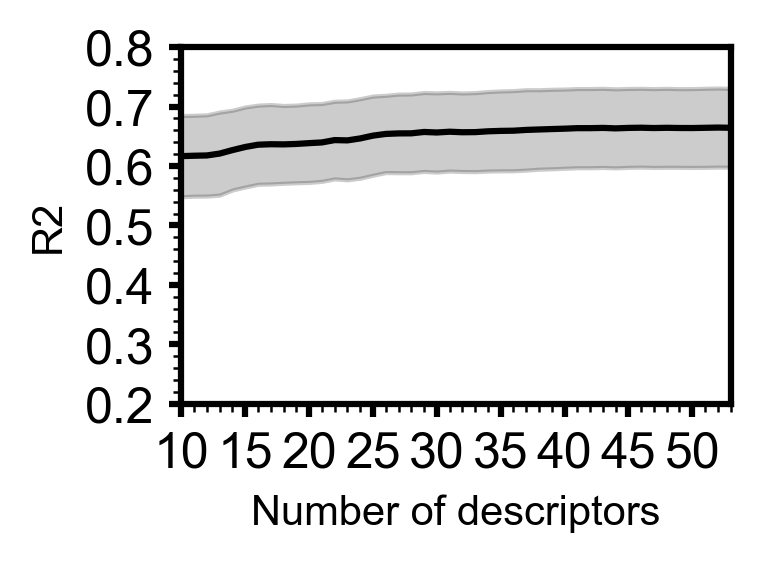

In [53]:
inch2cm=1/2.54
plt.figure(figsize=(6*inch2cm, 4*inch2cm))
plt.rcParams["figure.dpi"] = 300  # 分辨率
plt.rc('font',family='Arial',weight='normal')
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 10,
}

plt.plot(random_Number, R2_MEAN, '-', color='k',label='Random')
plt.fill_between(random_Number,R2_MEAN-R2_STD,R2_MEAN+R2_STD,
                 color='k', alpha=0.2)

plt.xlim(10,53)
plt.ylim(0.2,0.8)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
my_x_ticks = np.arange(10,53,5)
my_y_ticks = np.arange(0.2,0.81,0.1)
plt.xticks(my_x_ticks,size=12)
plt.yticks(my_y_ticks,size=12)
plt.grid(False)
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="out", width=1.5, length=3)
TK = plt.gca()
bwith = 1.5
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
TK.spines['bottom'].set_color('k')
TK.spines['left'].set_color('k')
TK.spines['top'].set_color('k')
TK.spines['right'].set_color('k')
plt.xlabel("Number of descriptors",fontsize=10)
plt.ylabel("R2",fontsize=10)
plt.show()

C:\Users\huang\AppData\Local\Temp/ipykernel_69348/2868686199.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot()


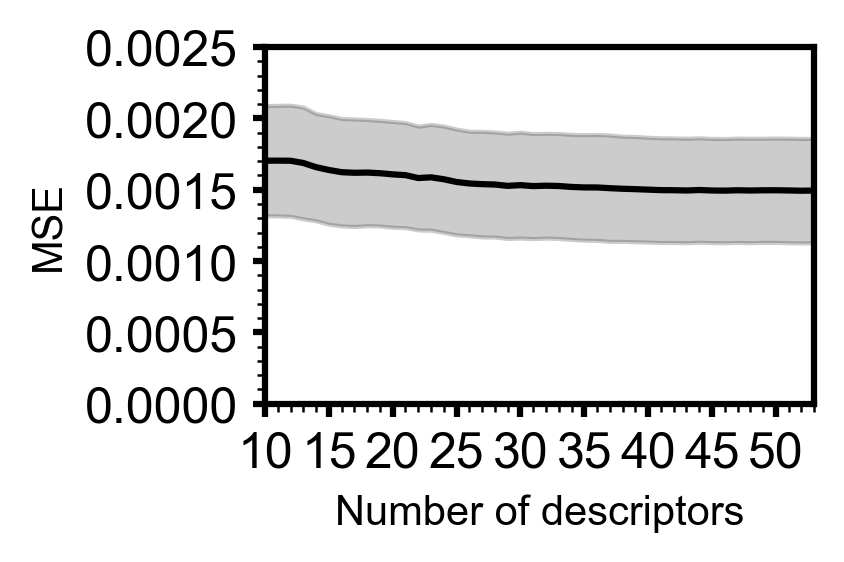

In [54]:
inch2cm=1/2.54
plt.figure(figsize=(6*inch2cm, 4*inch2cm))
plt.rcParams["figure.dpi"] = 300  # 分辨率
plt.rc('font',family='Arial',weight='normal')
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 10,
}
plt.plot(random_Number, MSE_MEAN, '-', color='k',label='Random')
plt.fill_between(random_Number,MSE_MEAN-MSE_STD,MSE_MEAN+MSE_STD,
                 color='k', alpha=0.2)
plt.xlim(10,53)
plt.ylim(0,0.002)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
my_x_ticks = np.arange(10,53,5)
my_y_ticks = np.arange(0,0.003,0.0005)
plt.xticks(my_x_ticks,size=12)
plt.yticks(my_y_ticks,size=12)
plt.grid(False)
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="out", width=1.5, length=3)
TK = plt.gca()
bwith = 1.5
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
TK.spines['bottom'].set_color('k')
TK.spines['left'].set_color('k')
TK.spines['top'].set_color('k')
TK.spines['right'].set_color('k')
plt.xlabel("Number of descriptors",fontsize=10)
plt.ylabel("MSE",fontsize=10)
plt.show()

In [55]:
rfe = RFE(estimator=rf, n_features_to_select=25)
model = rf
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv =RepeatedKFold(n_splits=10, n_repeats=1,random_state=1)
scores = cross_val_score(model, X, y_all, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
scores_mse=cross_val_score(model,  X, y_all,  scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MSE: %.3f (%.3f)' % (mean(scores_mse), std(scores_mse)))
print('R2: %.3f (%.3f)' % (mean(scores), std(scores)))

MSE: -0.001 (0.001)
R2: 0.664 (0.133)


In [56]:
selector =rfe.fit(X, y_all)

In [58]:
sele=selector.ranking_
feature_name=X_all.columns
feature_name

Index(['Monomer_length', 'MW_ratio', 'Mass_max', 'Mass_ave', 'K_bond_min',
       'K_bond_ave', 'K_ang_ave', 'Theta0_min', 'nAtom', 'nH', 'nN', 'nF',
       'nCl', 'AATS0dv', 'AATS0d', 'AATS0Z', 'AATS1Z', 'ATSC2Z', 'ATSC5Z',
       'AATSC0dv', 'AATSC0Z', 'AATSC2Z', 'BCUTdv-1h', 'BCUTd-1h', 'BCUTZ-1h',
       'C1SP2', 'Xc-3d', 'Xc-5d', 'Xc-6d', 'NssssC', 'ETA_eta_B', 'nHBDon',
       'CIC0', 'CIC1', 'MIC0', 'MIC1', 'Kier2', 'Kier3', 'Mor02', 'Mor04',
       'Mor08', 'Mor13', 'Mor14', 'Mor19', 'Mor31', 'SMR_VSA1', 'SMR_VSA3',
       'SlogP_VSA5', 'SlogP_VSA10', 'EState_VSA1', 'EState_VSA5',
       'VSA_EState4', 'VSA_EState7'],
      dtype='object')

In [65]:
Opt_desc=[]
for i in range (0,len(sele)):
    if sele[i]==1:
        Opt_desc.append(feature_name[i])
df1=df[Opt_desc]
to_save=df[["ID","TC"]].join(df1)
file1 = r"Opt_descriptor.pkl"
to_save.to_pickle(path+file1)        

In [66]:
to_save

,ID,TC,Monomer_length,MW_ratio,Mass_max,Mass_ave,K_bond_ave,K_ang_ave,nH,AATS0d,...,nHBDon,MIC0,MIC1,Kier3,Mor02,Mor14,Mor19,SMR_VSA1,SMR_VSA3,VSA_EState4
0,PI1,0.456185,2.58,1,12.011,4.67567,325.817,48.657,4,1.75,...,0,6.5095,6.5095,4,13.5611,0.233769,0.205252,0,0,0
1,PI2,0.258773,2.6,0.666667,12.011,4.67567,326.68,49.1032,6,2,...,0,6.62105,11.813,4,19.2292,0.393246,0.421298,0,0,0
2,PI3,0.264363,2.65,0.5,12.011,4.67567,327.04,48.9532,8,2,...,0,6.66736,13.5308,3,21.9293,0.675759,0.350261,0,0,0
3,PI4,0.261131,2.59,0.4,12.011,4.67567,327.256,48.8663,10,2,...,0,6.69093,13.4804,3.84,24.7537,0.923227,0.823443,0,0,0
4,PI5,0.234342,2.76,0.4,12.011,4.67567,327.256,49.2038,10,2.11765,...,0,6.69093,13.4804,2.66667,25.6625,0.872534,0.819376,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,PI1134,0.239876,19.74,0.745552,18.998,9.71751,372.619,69.222,16,4.42105,...,2,16.7388,33.6424,5.776,43.1547,-0.537266,0.199954,26.3425,19.9359,-0.487784
1047,PI1135,0.248861,19.43,0.745552,18.998,9.71751,372.619,69.222,16,4.42105,...,2,16.7388,33.6424,5.776,44.1209,-0.00156469,0.0888365,26.3425,19.9359,-0.466391
1048,PI1136,0.208098,15.11,1,32.067,8.37947,377.212,62.7439,18,3.05,...,2,22.0525,31.724,9.03686,44.7162,1.69004,1.14708,16.8356,9.44419,0
1049,PI1137,0.199093,5.34,1,32.067,10.7818,398.584,67.9282,4,3.86667,...,0,21.4168,27.4301,2.5,13.9872,-0.13399,-0.108499,8.4178,0,0
